# Image Segmentation with U-Net

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import keras.layers as tfl
import matplotlib.pyplot as plt
import imageio

### Load the data

In [2]:
image_path = '/home/abdalla/Datasets/Segment/data/CameraRGB/'
mask_path = '/home/abdalla/Datasets/Segment/data/CameraMask/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

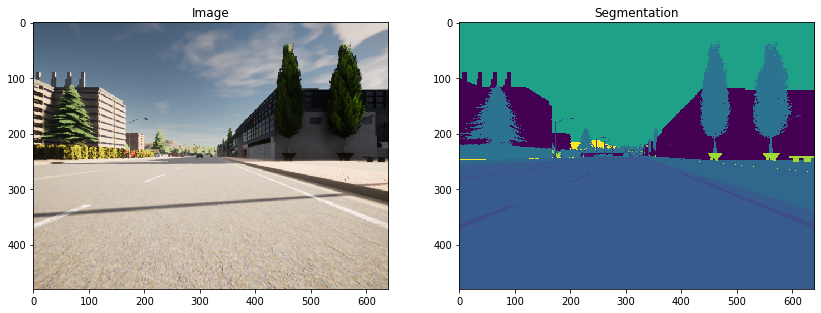

In [3]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, ax = plt.subplots(1, 2, figsize=(14, 10))
ax[0].imshow(img)
ax[0].set_title('Image')
ax[1].imshow(mask[:, :, 0])
ax[1].set_title('Segmentation')

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask


In [7]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

### U-Net blocks

In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Inputs:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = tfl.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    conv = tfl.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = tfl.Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = tfl.MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Inputs:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
        
    Returns: 
        conv -- Tensor output
    """
    
    up = tfl.Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = tfl.concatenate([up, contractive_input], axis=3)
    
    conv = tfl.Conv2D(n_filters,   # Number of filters
                 (3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    
    conv = tfl.Conv2D(n_filters,  # Number of filters
                 (3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [10]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Inputs:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
        
    Returns: 
        model -- tf.keras.Model
    """
    
    inputs = tfl.Input(input_size)
    
    # Contracting Path (encoding)
    
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    
    # Add the first upsampling_block.
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = tfl.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = tfl.Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### Helper function

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [12]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

### Train the model

In [13]:
img_height = 96
img_width = 128
num_channels = 3

model = unet_model((img_height, img_width, num_channels))

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(processed_image_ds.element_spec)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


In [17]:
model_history = model.fit(train_dataset, epochs=EPOCHS)

Epoch 1/10
34/34 [==============================] - 178s 5s/step - loss: 2.1008 - accuracy: 0.3745
Epoch 2/10
34/34 [==============================] - 161s 5s/step - loss: 0.8165 - accuracy: 0.7891
Epoch 3/10
34/34 [==============================] - 161s 5s/step - loss: 0.5480 - accuracy: 0.8477
Epoch 4/10
34/34 [==============================] - 161s 5s/step - loss: 0.4369 - accuracy: 0.8717
Epoch 5/10
34/34 [==============================] - 160s 5s/step - loss: 0.5047 - accuracy: 0.8553
Epoch 6/10
34/34 [==============================] - 162s 5s/step - loss: 0.3731 - accuracy: 0.8889
Epoch 7/10
34/34 [==============================] - 164s 5s/step - loss: 0.3283 - accuracy: 0.9001
Epoch 8/10
34/34 [==============================] - 166s 5s/step - loss: 0.2931 - accuracy: 0.9101
Epoch 9/10
34/34 [==============================] - 169s 5s/step - loss: 0.2508 - accuracy: 0.9249
Epoch 10/10
34/34 [==============================] - 162s 5s/step - loss: 0.2391 - accuracy: 0.9292


### Evaluate the model

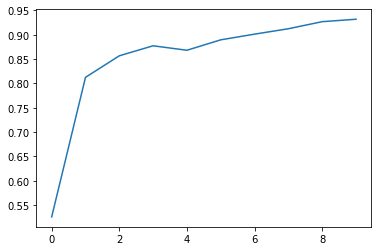

In [19]:
plt.plot(model_history.history["accuracy"])

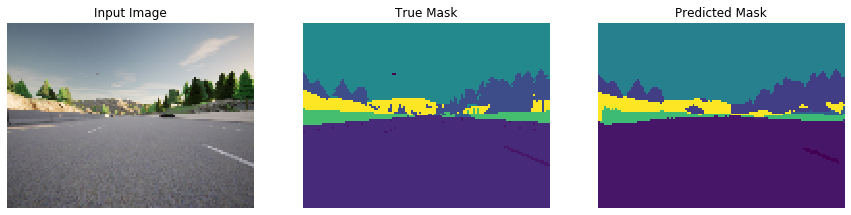

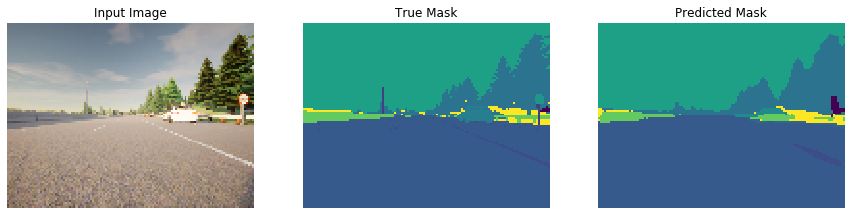

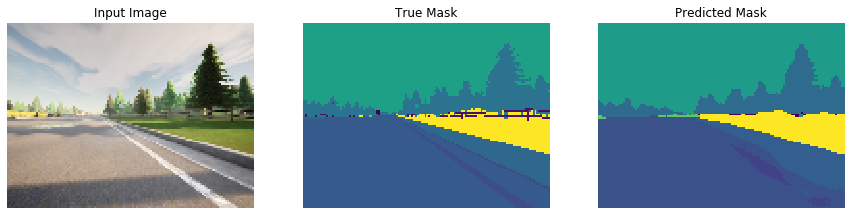

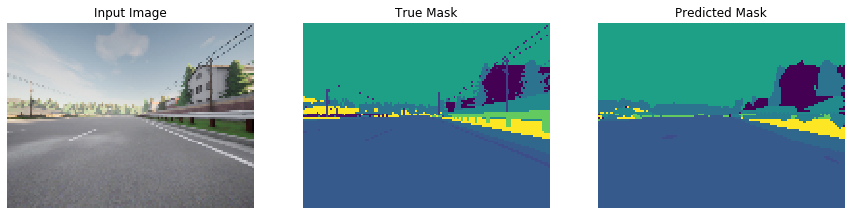

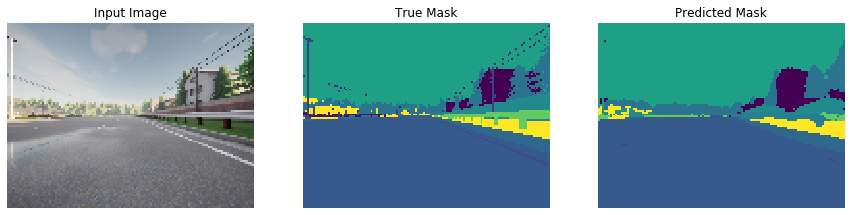

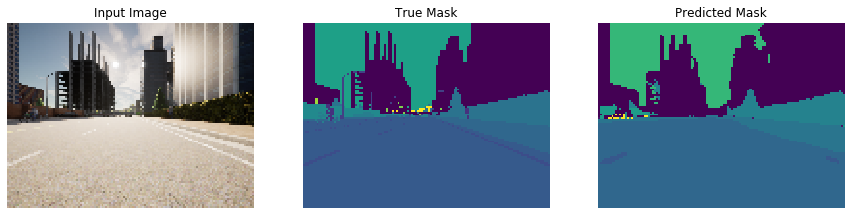

In [20]:
show_predictions(train_dataset, 6)

# DONE :D